In [56]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from  sklearn.linear_model import LogisticRegression
import re

In [68]:
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')

# Plot Data

## Pricing

<Figure size 640x480 with 0 Axes>

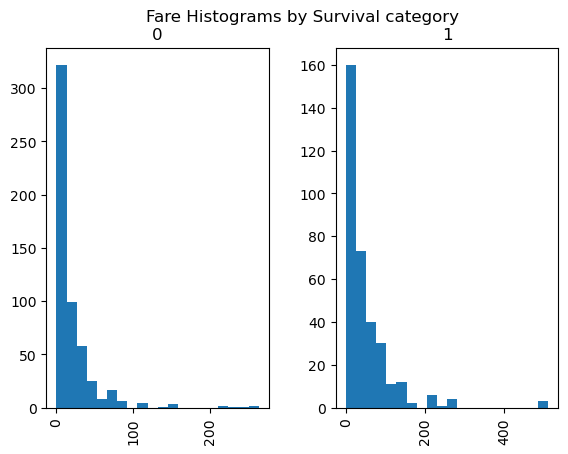

In [4]:
plt.figure(1)
train_original.hist(column='Fare', by='Survived', bins=20, grid=False)
plt.suptitle('Fare Histograms by Survival category')
plt.show()

# Preprocessing

Obtain expected values from dataset

In [69]:
y = train_original.pop('Survived')

## Fill or remove undefined data

We print the amount of missing data in the dataset.

Then we can remove the Cabin column since there is more than half the data missing, for the Age and Embarked columns we can impute those values

In [31]:
def check_for_nulls(df):
  nulls = (df.isnull().sum())
  nulls = nulls[nulls > 0] 
  if len(nulls) > 0:
    print(nulls)
  else:
    print('No nulls values found')
  print('total: ', len(df))
check_for_nulls(train_original)
check_for_nulls(test_original)

Age         177
Cabin       687
Embarked      2
dtype: int64
total:  891
Age       86
Fare       1
Cabin    327
dtype: int64
total:  418


In [7]:
def remove_columns(df):
  remove_cols = ['PassengerId', 'Cabin']
  return df[[col for col in df.columns if col not in remove_cols]]

In [21]:
def create_imputer(df):
  my_imputer = SimpleImputer(strategy='most_frequent')
  columns_to_impute = ['Age', 'Embarked', 'Fare']
  my_imputer.fit(df[columns_to_impute])
  def imputer(df):
    df = df.copy()
    data_with_imputed_values = my_imputer.transform(df[columns_to_impute])
    df_imputed = pd.DataFrame(data=data_with_imputed_values, columns=columns_to_impute)
    df_imputed.Age = df_imputed.Age.astype('float32')
    df[columns_to_impute] = df_imputed
    return df
  return (imputer(df), imputer)


In [9]:
def extract_person_title(df):
  df = df.copy()
  df['Title'] = df.pop('Name').apply(lambda x: re.search('(?<=,\s).*?\.', x).group(0))
  return df

In [10]:
def hot_encoding(df, columns=None):
  """Hot encodding 'Ticket' column"""
  df = df.copy()
  hot_encodings = []
  for col in ['Ticket', 'Sex', 'Embarked', 'Title']:
    hot_encoding = pd.get_dummies(df.pop(col))
    # remove the last column which is reduntant
    hot_encoding = hot_encoding.iloc[:, :-1]
    hot_encodings.append(hot_encoding)
  df = pd.concat([df, *hot_encodings], axis=1)
  if columns is not None and len(columns) > 0:
    df = df.reindex(columns=columns,fill_value=0)
  return df

In [47]:
def normalize_data(df, scaler=None):
  if scaler is None:
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)
  scaled_data = scaler.transform(df)
  print(type(scaled_data))
  print(scaled_data.dtype)
  print(scaled_data.shape)
  df = pd.DataFrame(scaled_data, columns=df.columns)
  return df, scaler
  

In [50]:
def preprocessing(df, mode='train', imputer=None, columns=None, scaler=None):
  if mode != 'train' and not callable(imputer): 
    raise Exception('if you are not training, you need to provide an imputer for the data')
  df = remove_columns(df)
  if mode == 'train':
    df, imputer = create_imputer(df)
  else:
    df = imputer(df)
  df = extract_person_title(df)
  df = hot_encoding(df, columns=columns)
  if mode == 'train':
    df, scaler = normalize_data(df)
  else:
    df, _ = normalize_data(df, scaler)
  return df, imputer

In [51]:
train, imputer = preprocessing(train_original)
test, _ = preprocessing(test_original, mode='test', imputer=imputer, columns=train.columns)

<class 'numpy.ndarray'>
float64
(891, 704)
<class 'numpy.ndarray'>
float64
(418, 704)


In [52]:
check_for_nulls(train)
check_for_nulls(test)

No nulls values found
total:  891
No nulls values found
total:  418


# Model

## Divide training data into training and validating data

In [70]:
l = train.shape[0] // 4

val_data = train[:l]
val_y = y_train[:l]
train_data = train[l:]
train_y = y[l:]


## Create model

In [86]:
model = LogisticRegression(max_iter=1000, verbose=0)
# model.fit(train_data,train_y)
model.fit(train,y)

LogisticRegression(max_iter=1000)

In [87]:
print(model.score(train_data, train_y))
print(model.score(val_data, val_y))

0.8923766816143498
0.8963963963963963


## Compare validation results to expected

In [63]:
def get_prediction(md, v_data):
  val_prediction = md.predict(v_data)
  val_prediction[val_prediction >= 0.5] = 1
  val_prediction[val_prediction < 0.5] = 0
  val_pred = val_prediction.flatten()
  return val_pred

def compare_resutls_to_pred(md, v_data, v_y):
  val_pred = get_prediction(md, v_data)
  val_y_array = v_y.to_numpy()
  diffs = abs(val_y_array - val_pred)
  #wrong_indices = np.where(diffs == 1)
  # print(wrong_indices)
  # previous: (array([ 10,  17,  18,  20,  36,  41,  74,  81,  83, 100, 107, 113, 119,
  #  127, 137, 140, 146, 199, 204, 205, 207, 220])
  wrongs_number = sum(diffs)
  print(wrongs_number)
  print(f'{int(wrongs_number)} wrong predcitions out of {v_y.shape[0]}')
  print('{:.2f}% wrong'.format(int(wrongs_number) * 100 / v_y.shape[0]))

In [76]:
compare_resutls_to_pred(model, val_data, val_y)

34
34 wrong predcitions out of 222
15.32% wrong


## Predict Tests outputs

In [88]:
ans = get_prediction(model, test)
print(ans.shape)
ans_df = pd.DataFrame(ans)
ans_df.columns = ['Survived']
ps_id_label = 'PassengerId'
ans_df['Survived'] = ans_df['Survived'].astype(np.int16)
ans_df[ps_id_label] = test_original[ps_id_label]
print(ans_df.head())
print(ans_df.describe())

(418,)
   Survived  PassengerId
0         0          892
1         1          893
2         0          894
3         0          895
4         1          896
         Survived  PassengerId
count  418.000000   418.000000
mean     0.385167  1100.500000
std      0.487218   120.810458
min      0.000000   892.000000
25%      0.000000   996.250000
50%      0.000000  1100.500000
75%      1.000000  1204.750000
max      1.000000  1309.000000


In [89]:
file_name = 'my_answer_logistic_regression.csv'
ans_df.to_csv(file_name, columns=['PassengerId', 'Survived'], index=False)

In [90]:
!cat $file_name | head

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
